In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

data = np.load('../data.npy', allow_pickle=True)

# Shuffle dataset
np.random.seed(1337)
np.random.shuffle(data)

train, val, test = np.split(data, [int(.75*len(data)), int(.80*len(data))])

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
# Normalize data. Pixels are [0, 255], so dividing will place them into a [0, 1] range.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# Resize all images into a common size of 150 x 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [4]:
baseline = tf.keras.models.load_model('../saved_models/baseline')

2021-09-25 12:06:27.630501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 12:06:27.638480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 12:06:27.639044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 12:06:27.639937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
attention = tf.keras.models.load_model('../saved_models/my_model')

In [8]:
from utils.vizgradcam.gradcam import VizGradCAM

In [65]:
ids = [65, 230, 422, 648, 961]

In [66]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 856]
 [  1 316]]


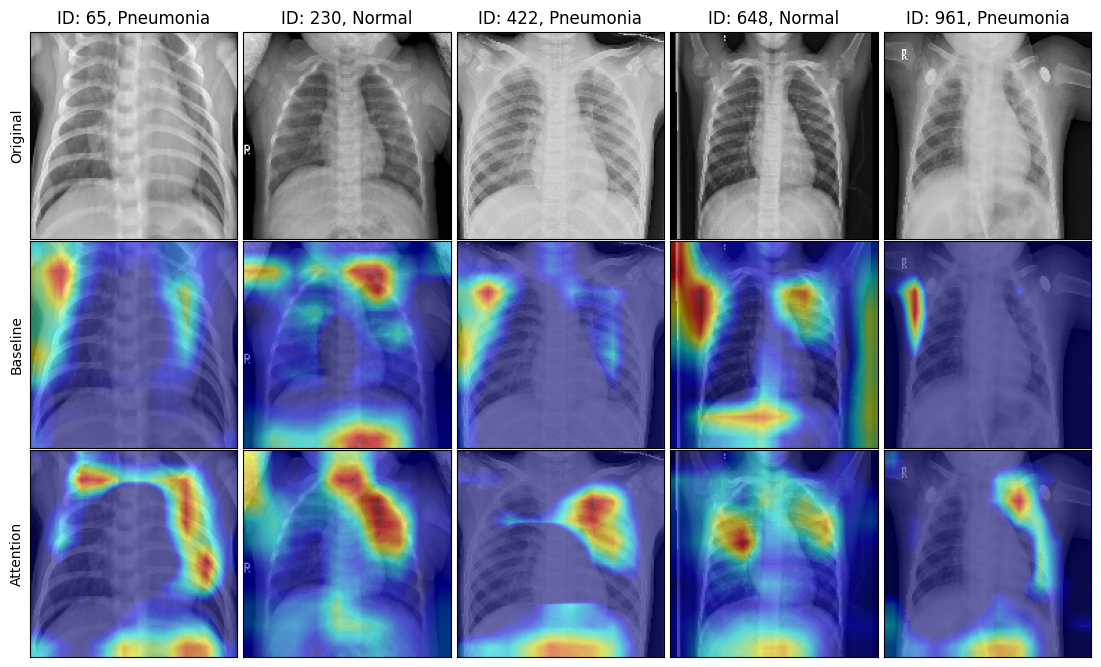

In [75]:
nums = len(ids)

fig, ax = plt.subplots(3, nums, figsize=(13.7, 8.3))
for column in range(nums):
    img = x_test[ids[column]]
    label = y_test[ids[column]]
    label = 'Pneumonia' if label == 0 else 'Normal'
    
    ax[0][column].imshow(img, cmap='gray')
    ax[0][column].set_xticks([])
    ax[0][column].set_yticks([])
    
    gradcambase = VizGradCAM(baseline, img, plot_results=False, return_scan=True)
    ax[1][column].imshow(gradcambase)
    ax[1][column].set_xticks([])
    ax[1][column].set_yticks([])
    
    gradcamatt = VizGradCAM(attention, img, plot_results=False, return_scan=True)
    ax[2][column].imshow(gradcamatt)
    ax[2][column].set_xticks([])
    ax[2][column].set_yticks([])

    ax[0][column].set(title=f'ID: {ids[column]}, {label}', ylabel='Original')
    ax[0][column].label_outer()
    
    ax[1][column].set(ylabel='Baseline')
    ax[1][column].label_outer()
    
    ax[2][column].set(ylabel='Attention')
    ax[2][column].label_outer()
    
plt.subplots_adjust(wspace=0.03, hspace=0)

plt.savefig('comparison')